## __Tutorial on binary stars using ESA's Gaia DR3 Data__

### _The goal of this Hands-on is to be able to use the data from the DR3 non-single star (NSS) data from ESA's Gaia satellite and compute masses and luminosities of binary stars_

*Nicolas Leclerc* and *Frédéric Arenou*

###  1 - Before you start (if not already done)


In [2]:
# Libraries used in the notebook
%pip install numpy pandas matplotlib astroquery nsstools sympy
%pip install --upgrade numpy matplotlib pandas

import pandas
import numpy as np
import matplotlib.pyplot as plt
import sympy as sy
from pathlib import Path
from astroquery.gaia import Gaia
from nsstools import NssSource
from multiprocessing import Pool, cpu_count

pandas.set_option('display.max_columns', None)
import matplotlib
print(f"Matplotlib version: {matplotlib.__version__}, Pandas version: {pandas.__version__}")

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Matplotlib version: 3.8.0, Pandas version: 2.1.1


<ins>Exercise 1:</ins> Write a code which execute your ADQL query asynchronously and return a pandas dataframe, remove the result on the ESA server, and return the result.

In [3]:
# If you want to connect to the Gaia archive, put your username and password, one by line in the file $HOME/.gaia_credentials
# Don't forget to protect the file with chmod 600 $HOME/.gaia_credentials
from pathlib import Path
gaia_credentials = Path.home() / ".gaia_credentials"

def query(adql):
    if gaia_credentials.exists():
        Gaia.login(credentials_file=gaia_credentials)
    job = Gaia.launch_job_async(adql)
    result = job.get_results().to_pandas()
    Gaia.remove_jobs(job.jobid)
    if gaia_credentials.exists():
        Gaia.logout()
    return result

### 2 - Counting all kinds of orbital solutions 

In the GACS database, the table ```gaiadr3.nss_two_body_orbit``` contains all orbits found.

<ins>Exercise 2:</ins> Write an ADQL query which allows to count for each ```nss_solution_type``` the number of sources which have this solution type.
Count also the total number of sources. Can you find sources having several kind of orbits ? 

In [4]:
types = query("SELECT nss_solution_type, count(*) FROM gaiadr3.nss_two_body_orbit GROUP BY nss_solution_type")
types

INFO: Query finished. [astroquery.utils.tap.core]
Removed jobs: '1696515209386O'.


nss_solution_type  COUNT_ALL
0                  AstroSpectroSB1      33467
1                  EclipsingBinary      86918
2                 EclipsingSpectro        155
3                          Orbital     134598
4               OrbitalAlternative        619
5      OrbitalAlternativeValidated         10
6            OrbitalTargetedSearch        345
7   OrbitalTargetedSearchValidated        188
8                              SB1     181327
9                             SB1C        202
10                             SB2       4630
11                            SB2C        746

In [5]:
countBySrcId = query("""
    SELECT count(*) 
    FROM (
        SELECT count(*) as count_src 
        FROM gaiadr3.nss_two_body_orbit 
        GROUP BY source_id) c 
    WHERE c.count_src > 1""")
print("Source id with more than 1 solution:", countBySrcId.iloc[0,0])

INFO: Query finished. [astroquery.utils.tap.core]
Removed jobs: '1696515210301O'.
Source id with more than 1 solution: 5926


In [29]:
# Or other solutions:
countBySrcId = query("""
    SELECT count(*) 
    FROM (
        SELECT count(*) as count_src 
        FROM gaiadr3.nss_two_body_orbit 
        GROUP BY source_id
        HAVING count(source_id) > 1) c 
    """)
print("Source id with more than 1 solution:", countBySrcId.iloc[0,0])

INFO: Query finished. [astroquery.utils.tap.core]
Removed jobs: '1696515422104O'.
Source id with more than 1 solution: 5926


In [30]:
# You can also distinguish between source_id with 1, 2 or 3 nss_solution_type
query("""
    SELECT c.count_src, count(*) 
    FROM (
        SELECT count(*) as count_src 
        FROM gaiadr3.nss_two_body_orbit 
        GROUP BY source_id) c 
    GROUP BY c.count_src""")


INFO: Query finished. [astroquery.utils.tap.core]
Removed jobs: '1696515603433O'.


count_src  COUNT_ALL
0          3          4
1          2       5922
2          1     431349

In [6]:
countall = query("SELECT count(*) FROM gaiadr3.nss_two_body_orbit")
print("Number of solution:", countall.iloc[0,0])

INFO: Query finished. [astroquery.utils.tap.core]
Removed jobs: '1696515211253O'.
Number of solution: 443205


### 3 - Detecting heavy compact companions in the Catalogue

In this first step, we will consider binary stars where the secondary emits no or few light only, i.e. the photocenter is on the primary star. 

With DR3 data, a dormant black hole was found, companion of __Gaia DR3 4373465352415301632__ (aka Gaia BH1). It was detected thanks to the NSS astrometric orbital solution ([El Badry et al., 2022](https://ui.adsabs.harvard.edu/abs/2023MNRAS.518.1057E/abstract)) by selecting the largest astrometric mass functions,
$$
\frac{M_2^3}{(M_1 + M_2)^2} = \frac{a_1^3}{P^2}
$$, 
where the orbital period $P$ is in yr and the semi-major axis of the primary $a_1$ in au, and the right-hand side is known from the orbit. When a secondary star emits no light but its mass is much large than the mass of the visible, primary star, this mass function is of the order of the secondary mass.

<ins>Exercise 3:</ins> Find where this equation comes from. 

Then, assuming that the secondary does not contribute to the light, i.e. that the semi-major axis of the photocenter is that of the primary, $a_1 \approx a_0$, we will now search for the largest astrometric mass functions in the Catalogue. So, first write an ADQL query which downloads a dataframe with the source_id, period and Thiele-Innes elements, and associated uncertainties, for all orbital solutions having very good solutions (goodness_of_fit < 1, parallax_error < 0.02).

Note that the angular semi-major axis of the photocenter $\mathring{a_0}$  is not part of the Catalogue, it has to be computed from the Thiele-Innes elements, using the [nsstools](https://gitlab.obspm.fr/gaia/nsstools) package. 

The $3^{rd}$ Kepler law in convenient units is:
$$
  \frac{a^3}{P^2} = \frac{(a_1+ a_2)^3}{P^2} = M_1 + M_2
$$
  - The semi-major axis of primary and secondary stars, $a_1$ and $a_2$, and of the relative orbit $a$, in au
  - The period $P$ is in yr
  - The masses of the primary and the secondary $M_1$ and $M_2$ in M☉  

By definition of the center of mass
$$
  a_1 M_1 = a_2 M_2
$$
Rewriting the Kepler law
$$
  \frac{(a_1 + \frac{a_1 \cdot M_1}{M_2})^3}{P^2} = M_1 + M_2
$$
$$
 \Rightarrow \frac{a_1^3}{P^2} \cdot (1+\frac{M_1}{M_2})^3 = \frac{a_1^3}{p^2} \cdot \frac{(M_1 + M_2)^3}{M_2^3} = M_1 + M_2
$$
$$
 \Rightarrow \frac{M_2^3}{(M_1 + M_2)^2} = \frac{a_1^3}{P^2}
$$

Note the need to change the units from what is contained in the Catalogue:
 - The period is given in days (it has to be divided by 365.25)
 - From the Thiele-Innes elements, the angular semi-major axis of the photocenter $\mathring{a_0}$ is obtained in mas, it has to be divided by the parallax $a_0 = \mathring{a_0}/\varpi$

If the secondary emits few flux, $a_1 \approx a_0$


In [7]:
fields = ["ra", "dec", "parallax", "pmra", "pmdec", "a_thiele_innes", "b_thiele_innes", "f_thiele_innes",
          "g_thiele_innes", "c_thiele_innes", "h_thiele_innes", "eccentricity", "period", "t_periastron"]

# for each field above, prefix with tbo. and create a new list with all errors corresponding to each field
fields = [f"tbo.{f}" for f in fields]
fields_error = [f"{f}_error" for f in fields]

adql = f"""
SELECT tbo.source_id, tbo.corr_vec, tbo.nss_solution_type, {", ".join(fields)}, {", ".join(fields_error)},
    gs.bp_rp, gs.phot_g_mean_mag, gs.parallax, gs.parallax_error
FROM gaiadr3.nss_two_body_orbit tbo
    INNER JOIN gaiadr3.gaia_source gs 
    ON gs.source_id = tbo.source_id
WHERE tbo.nss_solution_type = 'Orbital' AND tbo.goodness_of_fit < 1 AND tbo.parallax_error < 0.02
"""
df_gaiaCompacts = query(adql)
df_gaiaCompacts

INFO: Query finished. [astroquery.utils.tap.core]
Removed jobs: '1696515212502O'.


source_id                                           corr_vec  \
0      5706134738755178496  [-0.12127327, -0.27981114, -0.31976095, -0.658...   
1      5706291904496569984  [-0.19266406, -0.02896884, 0.12436111, -0.0338...   
2      5706321591310392960  [0.6765971, 0.08383255, 0.192776, -0.1834958, ...   
3      5706387768167388288  [0.44251359, -0.13007729, -0.022842897, -0.428...   
4      5706530292361510272  [-0.3196015, -0.032966405, 0.049438372, -0.041...   
...                    ...                                                ...   
31518  4612783300969159424  [0.56416446, 0.3183339, 0.18782042, 0.47529402...   
31519  5705240118544690304  [-0.23137219, 0.22619534, 0.10030623, -0.44758...   
31520  5705274130387988992  [0.75743324, 0.074161775, 0.2247296, -0.716429...   
31521  5705527400316308608  [0.3095083, 0.116620176, 0.13090515, 0.1940812...   
31522  5705589660162129920  [0.5544389, -0.24020949, -0.31822369, -0.21013...   

      nss_solution_type          ra        dec  parallax       pmra  \
0               Orbital  126.222140 -21.533409  0.888291  -1.388472   
1               Orbital  126.809640 -20.795600  1.012335  -4.756640   
2               Orbital  127.281667 -20.435139  0.906207  -6.476242   
3               Orbital  126.334044 -20.799923  1.240397 -11.919763   
4               Orbital  127.118346 -20.129764  1.166800 -10.095579   
...                 ...         ...        ...       ...        ...   
31518           Orbital   60.782116 -86.077705  1.685693  30.928924   
31519           Orbital  129.847479 -19.752494  0.826409  -5.373681   
31520           Orbital  130.212081 -19.481096  0.725174  -5.734271   
31521           Orbital  132.305066 -18.979232  1.253749  -4.405710   
31522           Orbital  131.741982 -18.820933  1.539712  -5.012900   

           pmdec  a_thiele_innes  b_thiele_innes  f_thiele_innes  \
0       3.242274       -0.354954        0.137856       -0.223271   
1      -2.657161        0.420284        0.160065       -0.250656   
2      -0.532705       -0.674535       -0.317353        0.143766   
3       3.654662       -0.105719        0.035256       -0.274885   
4       8.306437       -0.182854        0.447770        0.371077   
...          ...             ...             ...             ...   
31518  28.670954        0.643795        0.139446        0.187866   
31519  -1.589970       -0.074742        0.280740       -0.035603   
31520   1.929037       -0.415537       -0.531482        0.523383   
31521   5.367224        0.105618       -0.088027       -0.227116   
31522  -0.440860        0.369176        0.135372       -0.203209   

       g_thiele_innes  c_thiele_innes  h_thiele_innes  eccentricity  \
0           -0.192790             NaN             NaN      0.316612   
1            0.406280             NaN             NaN      0.044355   
2            0.236702             NaN             NaN      0.451416   
3           -0.400590             NaN             NaN      0.571047   
4            0.061287             NaN             NaN      0.389414   
...               ...             ...             ...           ...   
31518       -0.577659             NaN             NaN      0.598071   
31519       -0.361451             NaN             NaN      0.366066   
31520       -0.383908             NaN             NaN      0.756444   
31521       -0.139155             NaN             NaN      0.268644   
31522        0.041294             NaN             NaN      0.171114   

            period  t_periastron  ra_error  dec_error  parallax_error  \
0       645.666491   -197.428958  0.022311   0.041749        0.015159   
1       552.125771    179.905297  0.035893   0.042940        0.018401   
2      1233.815261    110.054499  0.036754   0.067661        0.016474   
3       502.855658    -56.369518  0.035904   0.030718        0.018533   
4       530.448928    100.311647  0.048744   0.028095        0.014309   
...            ...           ...       ...        ...             ...   
31518   46

<ins>Exercise 4:</ins> Now use nsstools package to convert the Thiele-Innes to Campbell and get $\mathring{a_0}$ and its uncertainty. The documentation is at [https://gitlab.obspm.fr/gaia/nsstools](https://gitlab.obspm.fr/gaia/nsstools). Merge the two dataframes to have all informations in the same dataframe, then compute the  astrometric mass function for all sources.

Plot an HR-diagram of these sources, using the astrometric mass function as 3rd dimension (colorbar between vmin=0 and vmax=0.1). Any comment ?

Find all sources with astrometric mass functions greater than 6 M☉ in the Catalogue.

In [8]:
# we convert to Campbell and merge the dataframes 
def allOrbitals_sequential(df_gaia):
    df_orbitals = df_gaia[df_gaia['nss_solution_type'] == 'Orbital'].reindex()
    df_campbell_processed = list()
    print(f"Launching the NssSource code for {df_orbitals.index.size} orbitals solutions on 1 processors...")
    for i in range(df_orbitals.index.size):
        source = NssSource(df_orbitals, indice=i)
        df_campbell_processed.append(source.campbell())
    concat_campbell = pandas.concat(df_campbell_processed, ignore_index=True)
    return pandas.merge(df_orbitals, concat_campbell, on='source_id')

# We can do better in parallel if we have many processors :
def process(args):
    df, row = args
    source = NssSource(df, indice=row)
    return source.campbell()

def allOrbitals_parallel(df_gaia):
    # We can do the same thing sequentially with for loops
    df_orbitals = df_gaia[df_gaia['nss_solution_type'] == 'Orbital'].reindex()
    params = [(df_orbitals, i) for i in range(df_orbitals.index.size)]
    print(f"Launching the NssSource code for {df_orbitals.index.size} orbitals solutions on {cpu_count()} processors...")
    with Pool(cpu_count()) as p:
        df_campbell_processed = p.map(process, params)
    concat_campbell = pandas.concat(df_campbell_processed, ignore_index=True)
    return pandas.merge(df_orbitals, concat_campbell, on='source_id')

all_orbits = allOrbitals_sequential(df_gaiaCompacts)
all_orbits

Launching the NssSource code for 31523 orbitals solutions on 1 processors...


source_id                                           corr_vec  \
0      5706134738755178496  [-0.12127327, -0.27981114, -0.31976095, -0.658...   
1      5706291904496569984  [-0.19266406, -0.02896884, 0.12436111, -0.0338...   
2      5706321591310392960  [0.6765971, 0.08383255, 0.192776, -0.1834958, ...   
3      5706387768167388288  [0.44251359, -0.13007729, -0.022842897, -0.428...   
4      5706530292361510272  [-0.3196015, -0.032966405, 0.049438372, -0.041...   
...                    ...                                                ...   
31518  4612783300969159424  [0.56416446, 0.3183339, 0.18782042, 0.47529402...   
31519  5705240118544690304  [-0.23137219, 0.22619534, 0.10030623, -0.44758...   
31520  5705274130387988992  [0.75743324, 0.074161775, 0.2247296, -0.716429...   
31521  5705527400316308608  [0.3095083, 0.116620176, 0.13090515, 0.1940812...   
31522  5705589660162129920  [0.5544389, -0.24020949, -0.31822369, -0.21013...   

      nss_solution_type          ra        dec  parallax       pmra  \
0               Orbital  126.222140 -21.533409  0.888291  -1.388472   
1               Orbital  126.809640 -20.795600  1.012335  -4.756640   
2               Orbital  127.281667 -20.435139  0.906207  -6.476242   
3               Orbital  126.334044 -20.799923  1.240397 -11.919763   
4               Orbital  127.118346 -20.129764  1.166800 -10.095579   
...                 ...         ...        ...       ...        ...   
31518           Orbital   60.782116 -86.077705  1.685693  30.928924   
31519           Orbital  129.847479 -19.752494  0.826409  -5.373681   
31520           Orbital  130.212081 -19.481096  0.725174  -5.734271   
31521           Orbital  132.305066 -18.979232  1.253749  -4.405710   
31522           Orbital  131.741982 -18.820933  1.539712  -5.012900   

           pmdec  a_thiele_innes  b_thiele_innes  f_thiele_innes  \
0       3.242274       -0.354954        0.137856       -0.223271   
1      -2.657161        0.420284        0.160065       -0.250656   
2      -0.532705       -0.674535       -0.317353        0.143766   
3       3.654662       -0.105719        0.035256       -0.274885   
4       8.306437       -0.182854        0.447770        0.371077   
...          ...             ...             ...             ...   
31518  28.670954        0.643795        0.139446        0.187866   
31519  -1.589970       -0.074742        0.280740       -0.035603   
31520   1.929037       -0.415537       -0.531482        0.523383   
31521   5.367224        0.105618       -0.088027       -0.227116   
31522  -0.440860        0.369176        0.135372       -0.203209   

       g_thiele_innes  c_thiele_innes  h_thiele_innes  eccentricity  \
0           -0.192790             NaN             NaN      0.316612   
1            0.406280             NaN             NaN      0.044355   
2            0.236702             NaN             NaN      0.451416   
3           -0.400590             NaN             NaN      0.571047   
4            0.061287             NaN             NaN      0.389414   
...               ...             ...             ...           ...   
31518       -0.577659             NaN             NaN      0.598071   
31519       -0.361451             NaN             NaN      0.366066   
31520       -0.383908             NaN             NaN      0.756444   
31521       -0.139155             NaN             NaN      0.268644   
31522        0.041294             NaN             NaN      0.171114   

            period  t_periastron  ra_error  dec_error  parallax_error  \
0       645.666491   -197.428958  0.022311   0.041749        0.015159   
1       552.125771    179.905297  0.035893   0.042940        0.018401   
2      1233.815261    110.054499  0.036754   0.067661        0.016474   
3       502.855658    -56.369518  0.035904   0.030718        0.018533   
4       530.448928    100.311647  0.048744   0.028095        0.014309   
...            ...           ...       ...        ...             ...   
31518   46

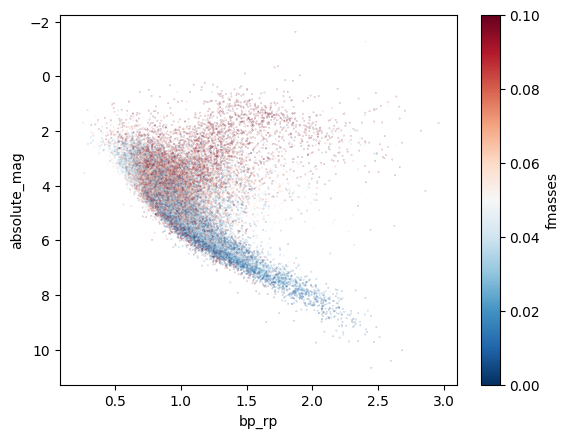

All sources with mass function > 6 M☉:


source_id                                           corr_vec  \
19093  4373465352415301632  [-0.9385065, -0.10964689, 0.09768217, 0.025997...   

      nss_solution_type          ra       dec  parallax     pmra      pmdec  \
19093           Orbital  262.171208 -0.581092  2.095452 -7.70205 -25.850421   

       a_thiele_innes  b_thiele_innes  f_thiele_innes  g_thiele_innes  \
19093       -0.262289        2.929116        1.524807        0.534369   

       c_thiele_innes  h_thiele_innes  eccentricity      period  t_periastron  \
19093             NaN             NaN      0.488936  185.765658     -12.02468   

       ra_error  dec_error  parallax_error  pmra_error  pmdec_error  \
19093  0.495897   0.150922        0.017456    0.020407     0.026994   

       a_thiele_innes_error  b_thiele_innes_error  f_thiele_innes_error  \
19093              0.169845              0.175218              0.153876   

       g_thiele_innes_error  c_thiele_innes_error  h_thiele_innes_error  \
19093              0.546531                   NaN                   NaN   

       eccentricity_error  period_error  t_periastron_error     bp_rp  \
19093            0.074341      0.306886            6.348962  1.174784   

       phot_g_mean_mag  parallax_2  parallax_error_2        a0  inclination  \
19093        13.771998    2.069989          0.116678  2.977516   121.304879   

       arg_periastron  nodeangle  a1  a0_error  inclination_error  \
19093      349.446979  89.588035 NaN  0.219492           3.108169   

       arg_periastron_error  nodeangle_error  a1_error    fmasses  \
19093             11.925546         3.758493       NaN  11.091217   

       absolute_mag  
19093      5.378387

In [9]:
all_orbits['fmasses'] = all_orbits.apply(lambda r: (r['a0'] / r['parallax'])**3 / (r['period'] / 365.25)**2, axis=1)
all_orbits['absolute_mag'] = all_orbits.apply(lambda r: r['phot_g_mean_mag'] + 5*np.log10(r['parallax']/1000) + 5, axis=1)
big_masses = all_orbits[all_orbits['fmasses'] > 6]

ax = all_orbits.plot.scatter(x='bp_rp', y='absolute_mag', c='fmasses', colormap='RdBu_r', s=0.01, vmin=0, vmax=0.1)
ax.invert_yaxis()
plt.show()
print("All sources with mass function > 6 M☉:")
big_masses

### 4 - Estimating the dynamical mass of a black hole companion

The black hole Gaia BH1 is within the list just found. In this exercise, we will estimate its mass. For this purpose, we need an estimate of the mass of the primary star: it can be found in the Gaia astrophysical parameters table ```gaiadr3.astrophysical_parameters```. 

<ins>Exercise 5:</ins> Can you write an ADQL query which permits to join all data from ```gaiadr3.nss_two_body_orbit``` and columns ```astroparams.mass_flame```, ```astroparams.mass_flame_lower```, ```astroparams.mass_flame_upper``` from ```gaiadr3.astrophysical_parameters``` for the ```source_id``` 4373465352415301632.
Then compute the semi-major axis from Thiele-Innes elements as before.

In [10]:
gaiabh1 = 4373465352415301632
adql = f"""
SELECT nss.*, astroparams.mass_flame, astroparams.mass_flame_lower, astroparams.mass_flame_upper
FROM gaiadr3.nss_two_body_orbit as nss 
    INNER JOIN gaiadr3.astrophysical_parameters as astroparams
    ON nss.source_id = astroparams.source_id
WHERE nss.source_id = {gaiabh1}
"""
df_gaiabh1 = query(adql)
df_gaiabh1

INFO: Query finished. [astroquery.utils.tap.core]
Removed jobs: '1696515372157O'.


solution_id            source_id nss_solution_type          ra  \
0  4338096422163308546  4373465352415301632           Orbital  262.171208   

   ra_error       dec  dec_error  parallax  parallax_error     pmra  \
0  0.495897 -0.581092   0.150922  2.095452        0.017456 -7.70205   

   pmra_error      pmdec  pmdec_error  a_thiele_innes  a_thiele_innes_error  \
0    0.020407 -25.850421     0.026994       -0.262289              0.169845   

   b_thiele_innes  b_thiele_innes_error  f_thiele_innes  f_thiele_innes_error  \
0        2.929116              0.175218        1.524807              0.153876   

   g_thiele_innes  g_thiele_innes_error  c_thiele_innes  c_thiele_innes_error  \
0        0.534369              0.546531             NaN                   NaN   

   h_thiele_innes  h_thiele_innes_error      period  period_error  \
0             NaN                   NaN  185.765658      0.306886   

   t_periastron  t_periastron_error  eccentricity  eccentricity_error  \
0     -12.02468            6.348962      0.488936            0.074341   

   center_of_mass_velocity  center_of_mass_velocity_error  \
0                      NaN                            NaN   

   semi_amplitude_primary  semi_amplitude_primary_error  \
0                     NaN                           NaN   

   semi_amplitude_secondary  semi_amplitude_secondary_error  mass_ratio  \
0                       NaN                             NaN         NaN   

   mass_ratio_error  fill_factor_primary  fill_factor_primary_error  \
0               NaN                  NaN                        NaN   

   fill_factor_secondary  fill_factor_secondary_error  inclination  \
0                    NaN                          NaN          NaN   

   inclination_error  arg_periastron  arg_periastron_error  temperature_ratio  \
0                NaN             NaN                   NaN                NaN   

   temperature_ratio_error  temperature_ratio_definition  \
0                      NaN                          <NA>   

   astrometric_n_obs_al  astrometric_n_good_obs_al  rv_n_obs_primary  \
0                   419                        417              <NA>   

   rv_n_good_obs_primary  rv_n_obs_secondary  rv_n_good_obs_secondary  \
0                   <NA>                <NA>                     <NA>   

   phot_g_n_obs  phot_g_n_good_obs  bit_index  \
0          <NA>               <NA>       8191   

                                            corr_vec    obj_func  \
0  [-0.9385065, -0.10964689, 0.09768217, 0.025997...  413.290894   

   goodness_of_fit  efficiency  significance  flags  conf_spectro_period  \
0         0.312771         0.0      13.56551     64                  NaN   

   r_pole_sum  r_l1_point_sum  r_spher_sum  ecl_time_primary  \
0         NaN             NaN          NaN               NaN   

   ecl_time_secondary  ecl_dur_primary  ecl_dur_secondary  g_luminosity_ratio  \
0                 NaN              NaN                NaN                 NaN   

   input_period_error  g_rank  astrometric_jitter  mass_flame  \
0                 NaN     NaN                 NaN    0.909138   

   mass_flame_lower  mass_flame_upper  
0          0.869138          0.949138

In [11]:
source = NssSource(df_gaiabh1, indice=0)
df_campbell_gaiabh1 = source.campbell()
df_merge_gaiabh1 = pandas.merge(df_gaiabh1, df_campbell_gaiabh1, on='source_id', suffixes=('_nss', ''))
df_merge_gaiabh1

solution_id            source_id nss_solution_type          ra  \
0  4338096422163308546  4373465352415301632           Orbital  262.171208   

   ra_error       dec  dec_error  parallax  parallax_error     pmra  \
0  0.495897 -0.581092   0.150922  2.095452        0.017456 -7.70205   

   pmra_error      pmdec  pmdec_error  a_thiele_innes  a_thiele_innes_error  \
0    0.020407 -25.850421     0.026994       -0.262289              0.169845   

   b_thiele_innes  b_thiele_innes_error  f_thiele_innes  f_thiele_innes_error  \
0        2.929116              0.175218        1.524807              0.153876   

   g_thiele_innes  g_thiele_innes_error  c_thiele_innes  c_thiele_innes_error  \
0        0.534369              0.546531             NaN                   NaN   

   h_thiele_innes  h_thiele_innes_error      period  period_error  \
0             NaN                   NaN  185.765658      0.306886   

   t_periastron  t_periastron_error  eccentricity  eccentricity_error  \
0     -12.02468            6.348962      0.488936            0.074341   

   center_of_mass_velocity  center_of_mass_velocity_error  \
0                      NaN                            NaN   

   semi_amplitude_primary  semi_amplitude_primary_error  \
0                     NaN                           NaN   

   semi_amplitude_secondary  semi_amplitude_secondary_error  mass_ratio  \
0                       NaN                             NaN         NaN   

   mass_ratio_error  fill_factor_primary  fill_factor_primary_error  \
0               NaN                  NaN                        NaN   

   fill_factor_secondary  fill_factor_secondary_error  inclination_nss  \
0                    NaN                          NaN              NaN   

   inclination_error_nss  arg_periastron_nss  arg_periastron_error_nss  \
0                    NaN                 NaN                       NaN   

   temperature_ratio  temperature_ratio_error  temperature_ratio_definition  \
0                NaN                      NaN                          <NA>   

   astrometric_n_obs_al  astrometric_n_good_obs_al  rv_n_obs_primary  \
0                   419                        417              <NA>   

   rv_n_good_obs_primary  rv_n_obs_secondary  rv_n_good_obs_secondary  \
0                   <NA>                <NA>                     <NA>   

   phot_g_n_obs  phot_g_n_good_obs  bit_index  \
0          <NA>               <NA>       8191   

                                            corr_vec    obj_func  \
0  [-0.9385065, -0.10964689, 0.09768217, 0.025997...  413.290894   

   goodness_of_fit  efficiency  significance  flags  conf_spectro_period  \
0         0.312771         0.0      13.56551     64                  NaN   

   r_pole_sum  r_l1_point_sum  r_spher_sum  ecl_time_primary  \
0         NaN             NaN          NaN               NaN   

   ecl_time_secondary  ecl_dur_primary  ecl_dur_secondary  g_luminosity_ratio  \
0                 NaN              NaN                NaN                 NaN   

   input_period_error  g_rank  astrometric_jitter  mass_flame  \
0                 NaN     NaN                 NaN    0.909138   

   mass_flame_lower  mass_flame_upper        a0  inclination  arg_periastron  \
0          0.869138          0.949138  2.977516   121.304879      349.446979   

   nodeangle  a1  a0_error  inclination_error  arg_periastron_error  \
0  89.588035 NaN  0.219492           3.108169             11.925546   

   nodeangle_error  a1_error  
0         3.758493       NaN

<ins>Exercise 6:</ins> Use the sympy package and the data in the dataframe to solve the implicit equation of the astrometric mass function and solve for the mass $M_2$ of the black hole. 

Now that you now how to obtain the mass, estimate its uncertainty using a Monte Carlo and plot the histogram of the $M_2$ values drawn.

In [12]:
m1 = df_merge_gaiabh1.loc[0, "mass_flame"]
a1 = df_merge_gaiabh1.loc[0, "a0"]/df_merge_gaiabh1.loc[0, "parallax"]
p = df_merge_gaiabh1.loc[0, "period"]/365.25

def kepler(m1, a1, p):
    m2 = sy.symbols('m2')
    eq = sy.Eq(m2**3/(m1 + m2)**2, a1**3/p**2)
    solution = sy.solve(eq)
    # return the first positive and real solution
    bh1mass = list(filter(lambda x: x.is_real and x > 0, solution))
    return bh1mass[0] if len(bh1mass) > 0 else None

def astrometric_mass_fonction(m1, a1, p):
    m2 = sy.symbols('m2')
    eq = sy.Eq((a1+(a1*m1/m2))**3/p**2, m1 + m2)
    solution = sy.solve(eq)
    # return the first positive and real solution
    bh1mass = list(filter(lambda x: x.is_real and x > 0, solution))
    return bh1mass[0] if len(bh1mass) > 0 else None

m2 = kepler(m1, a1, p)
m2bis = astrometric_mass_fonction(m1, a1, p)
print(f"M1={m1:.3f} M☉, a1={a1:.3f} au, P={p:.3f} years\nM2={m2:.3f} M☉ or M2={m2bis:.3f} M☉")

M1=0.909 M☉, a1=1.421 au, P=0.509 years
M2=12.732 M☉ or M2=12.732 M☉


In [13]:
m1_error = (df_merge_gaiabh1.loc[0, "mass_flame_upper"] - df_merge_gaiabh1.loc[0, "mass_flame_lower"])/2
a0_error = df_merge_gaiabh1.loc[0, "a0_error"]
parallax_error = df_merge_gaiabh1.loc[0, "parallax_error"]
p_error = df_merge_gaiabh1.loc[0, "period_error"]/365.25

print(f"M1_error: {m1_error:.3f} M☉, a0_error: {a0_error:.3f} mas\nparallax_error: {parallax_error:.3f} mas, P_error: {p_error:.3f} days")

M1_error: 0.040 M☉, a0_error: 0.219 mas
parallax_error: 0.017 mas, P_error: 0.001 days


In [14]:
def gaussianRandom(x_error):
    return x_error*np.random.randn(1)[0]

def monteCarlo(nbIterations=200):
    m2_list = np.array([])
    for i in range(nbIterations):
        m1 = df_merge_gaiabh1.loc[0, "mass_flame"] + gaussianRandom(m1_error)
        a1 = (df_merge_gaiabh1.loc[0, "a0"] + gaussianRandom(a0_error)) / (df_merge_gaiabh1.loc[0, "parallax"] + gaussianRandom(parallax_error))
        p = (df_merge_gaiabh1.loc[0, "period"] + gaussianRandom(p_error))/365.25
        m2 = kepler(m1, a1, p)
        if m2 is not None:
            m2_list = np.append(m2_list, m2)
        if i % 100 == 0:
            print(f"{i} iterations")
    print(f"{nbIterations} iterations")
    return m2_list.astype(np.float64)
  
m2_list = monteCarlo(300)


0 iterations
100 iterations
200 iterations
300 iterations


Standard deviation of M2: 2.517


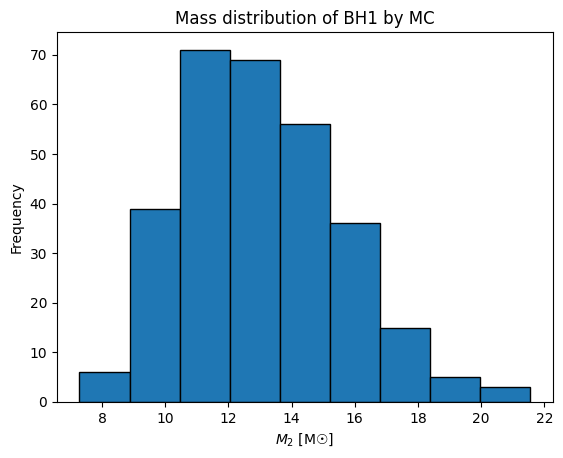

In [15]:
print(f"Standard deviation of M2: {np.std(m2_list):.3f}") 
nbins = int(1 + np.log2(np.size(m2_list)))

plt.hist(m2_list, bins=nbins, edgecolor='k')
plt.xlabel('$M_2$ [M☉]')
plt.ylabel('Frequency')
plt.title('Mass distribution of BH1 by MC')

plt.show()

In [16]:
median = np.median(m2_list)
mad = np.median(np.abs(m2_list - median))
robust_std = 1.4826 * mad
std = np.std(m2_list)

print(f"Mass of BH1 : {m2:.3f} ± {robust_std:.3f} M☉")

Mass of BH1 : 12.732 ± 2.637 M☉


In [17]:
solution = query(f"SELECT * from gaiadr3.binary_masses where source_id = {gaiabh1}")
solution

INFO: Query finished. [astroquery.utils.tap.core]
Removed jobs: '1696515416702O'.


source_id        m1  m1_lower  m1_upper        m2   m2_lower  \
0  4373465352415301632  0.954539  0.894769    1.0167  12.80625  10.489669   

    m2_upper  fluxratio  fluxratio_lower  fluxratio_upper combination_method  \
0  15.628846        NaN              0.0              0.0         Orbital+M1   

    m1_ref flag  
0  IsocLum

### 5 - Estimating the masses and luminosities of binaries when both companions emit light

In the general case, the photocenter is not on the primary and the astrometric mass function combines masses and luminosities:
$$
\left|{M_2\over{M1+M_2}} - {L_2\over{L_1+L_2}}\right |^3 (M_1+M_2) =  \frac{a_0^3}{P^2}
$$


External information is then needed to derive the mass of the components. When the source is also known as a SB2, the magic allows you to find not only the masses of the components but also their magnitude from the photocenter orbit. 

<ins>Exercise 7:</ins> Find in the Catalogue the sources which are both orbital astrometric and SB2 (or SB2C). Download the orbital parameters for the astrometric solution, and the radial velocity semi-amplitudes of primary and secondary together with their uncertainties for the SB2 solution.

In [18]:
orbital_fields = ["ra", "dec", "parallax", "pmra", "pmdec", "a_thiele_innes", "b_thiele_innes", "f_thiele_innes",
          "g_thiele_innes", "c_thiele_innes", "h_thiele_innes", "eccentricity", "period", "t_periastron"]

# for each field above, prefix with tbo. and create a new list with all errors corresponding to each field
orbital_fields = [f"tbo.{f}" for f in orbital_fields]
orbital_fields_error = [f"{f}_error" for f in orbital_fields]

df_sb2 = query(f"""
SELECT tbo.source_id, tbo.corr_vec, tbo.nss_solution_type, {", ".join(orbital_fields)}, {", ".join(orbital_fields_error)},
    sb2.semi_amplitude_primary, sb2.semi_amplitude_primary_error, sb2.semi_amplitude_secondary, sb2.semi_amplitude_secondary_error
FROM gaiadr3.nss_two_body_orbit tbo
INNER JOIN (
    SELECT source_id, semi_amplitude_primary, semi_amplitude_primary_error, semi_amplitude_secondary, semi_amplitude_secondary_error
    FROM gaiadr3.nss_two_body_orbit
    WHERE nss_solution_type='SB2' or nss_solution_type='SB2C') sb2
ON tbo.source_id = sb2.source_id
WHERE tbo.nss_solution_type = 'Orbital'""")

df_sb2

INFO: Query finished. [astroquery.utils.tap.core]
Removed jobs: '1696515417907O'.


source_id                                           corr_vec  \
0    1105311006155685888  [0.5677153, -0.364639, -0.4271285, 0.24144469,...   
1    3487083951918958464  [-0.27676097, 0.22454832, -0.022714442, 0.0107...   
2    5432348651157744128  [-0.68769044, -0.098066114, 0.018724889, 0.188...   
3    2209773494275339776  [0.39430788, 0.08780558, 0.20560648, -0.254529...   
4    6027732067367229312  [-0.62021047, 0.21032229, -0.42458647, -0.4974...   
..                   ...                                                ...   
96   3446387075207100032  [-0.70223767, 0.589942, -0.46985662, -0.609691...   
97   6369481893479499776  [-0.4711733, 0.26032174, -0.43253902, 0.219972...   
98   2040103113357673728  [-0.17576432, 0.0075517017, 0.042341672, 0.007...   
99    545570900834203776  [0.2716813, 0.33501095, -0.28174564, 0.0016322...   
100  4610854723214465024  [0.15834494, 0.104883336, 0.07550928, 0.019450...   

    nss_solution_type          ra        dec   parallax       pmra      pmdec  \
0             Orbital   93.761792  68.087858  12.410605  71.258989 -87.021309   
1             Orbital  179.212865 -27.473605  10.708712 -48.108735 -24.780491   
2             Orbital  147.352865 -38.349133   5.095656 -17.734357  25.521031   
3             Orbital  358.676658  66.354925   5.541786 -11.631374  -6.278419   
4             Orbital  253.651953 -31.334475  14.835891  -5.811976  20.221686   
..                ...         ...        ...        ...        ...        ...   
96            Orbital   80.185425  28.893232  24.182435 -29.378492   9.520943   
97            Orbital  312.567061 -75.038132   8.290787  22.527707 -64.248680   
98            Orbital  289.733686  32.396208   4.645048  -3.116586 -33.190431   
99            Orbital   40.503984  71.427752   1.362227  10.245358  -8.116768   
100           Orbital  268.145603  38.381222   7.106787  25.112147   9.478700   

     a_thiele_innes  b_thiele_innes  f_thiele_innes  g_thiele_innes  \
0          0.511356       -0.167269        0.484444        0.515152   
1         -1.010412       -0.136453        0.164082       -2.463162   
2          0.437094        0.024227       -0.264241        0.992539   
3          0.141847       -1.083306        1.516172        0.105149   
4          0.652945        0.860947        1.094433       -2.837514   
..              ...             ...             ...             ...   
96         1.975270       -0.160944        0.068745        1.278991   
97        -0.353970        0.154924       -0.192792       -0.211950   
98        -0.430795        0.503539        0.645377        0.819343   
99        -0.207501       -0.496327       -0.327537       -0.225352   
100        0.119884       -0.624189       -0.188122       -1.295866   

     c_thiele_innes  h_thiele_innes  eccentricity      period  t_periastron  \
0               NaN             NaN      0.397361  195.140227     20.549390   
1               NaN             NaN      0.220493  284.632043    119.784901   
2               NaN             NaN      0.427187  262.032187     73.694284   
3               NaN             NaN      0.171482  452.985183   -183.924096   
4               NaN             NaN      0.033741  410.693155    127.183148   
..              ...             ...           ...         ...           ...   
96              NaN             NaN      0.373637   56.087002     -1.719862   
97              NaN             NaN      0.135636  129.055673      3.473455   
98              NaN             NaN      0.452613  242.371379      7.342169   
99              NaN             NaN      0.543009  601.162813   -224.001642   
100             NaN             NaN      0.172777  245.590925    -99.026132   

     ra_error  dec_error  parallax_error  pmra_error  pmdec_error  \
0    0.032730   0.051870        0.021320    0.012792     0.017932   
1    0.052351   0.026445        0.018562    0.020574     0.014673   
2    0.053580   0.046353        0.019286    0.017180     0.016534   
3    0.042294  

In [19]:
df_allorbitals_sb2 = allOrbitals_sequential(df_sb2)
df_allorbitals_sb2.set_index("source_id", inplace=True)
df_allorbitals_sb2

Launching the NssSource code for 101 orbitals solutions on 1 processors...


corr_vec  \
source_id                                                                
1105311006155685888  [0.5677153, -0.364639, -0.4271285, 0.24144469,...   
3487083951918958464  [-0.27676097, 0.22454832, -0.022714442, 0.0107...   
5432348651157744128  [-0.68769044, -0.098066114, 0.018724889, 0.188...   
2209773494275339776  [0.39430788, 0.08780558, 0.20560648, -0.254529...   
6027732067367229312  [-0.62021047, 0.21032229, -0.42458647, -0.4974...   
...                                                                ...   
3446387075207100032  [-0.70223767, 0.589942, -0.46985662, -0.609691...   
6369481893479499776  [-0.4711733, 0.26032174, -0.43253902, 0.219972...   
2040103113357673728  [-0.17576432, 0.0075517017, 0.042341672, 0.007...   
545570900834203776   [0.2716813, 0.33501095, -0.28174564, 0.0016322...   
4610854723214465024  [0.15834494, 0.104883336, 0.07550928, 0.019450...   

                    nss_solution_type          ra        dec   parallax  \
source_id                                                                 
1105311006155685888           Orbital   93.761792  68.087858  12.410605   
3487083951918958464           Orbital  179.212865 -27.473605  10.708712   
5432348651157744128           Orbital  147.352865 -38.349133   5.095656   
2209773494275339776           Orbital  358.676658  66.354925   5.541786   
6027732067367229312           Orbital  253.651953 -31.334475  14.835891   
...                               ...         ...        ...        ...   
3446387075207100032           Orbital   80.185425  28.893232  24.182435   
6369481893479499776           Orbital  312.567061 -75.038132   8.290787   
2040103113357673728           Orbital  289.733686  32.396208   4.645048   
545570900834203776            Orbital   40.503984  71.427752   1.362227   
4610854723214465024           Orbital  268.145603  38.381222   7.106787   

                          pmra      pmdec  a_thiele_innes  b_thiele_innes  \
source_id                                                                   
1105311006155685888  71.258989 -87.021309        0.511356       -0.167269   
3487083951918958464 -48.108735 -24.780491       -1.010412       -0.136453   
5432348651157744128 -17.734357  25.521031        0.437094        0.024227   
2209773494275339776 -11.631374  -6.278419        0.141847       -1.083306   
6027732067367229312  -5.811976  20.221686        0.652945        0.860947   
...                        ...        ...             ...             ...   
3446387075207100032 -29.378492   9.520943        1.975270       -0.160944   
6369481893479499776  22.527707 -64.248680       -0.353970        0.154924   
2040103113357673728  -3.116586 -33.190431       -0.430795        0.503539   
545570900834203776   10.245358  -8.116768       -0.207501       -0.496327   
4610854723214465024  25.112147   9.478700        0.119884       -0.624189   

                     f_thiele_innes  g_thiele_innes  c_thiele_innes  \
source_id                                                             
1105311006155685888        0.484444        0.515152             NaN   
3487083951918958464        0.164082       -2.463162             NaN   
5432348651157744128       -0.264241        0.992539             NaN   
2209773494275339776        1.516172        0.105149             NaN   
6027732067367229312        1.094433       -2.837514             NaN   
...                             ...             ...             ...   
3446387075207100032        0.068745        1.278991             NaN   
6369481893479499776       -0.192792       -0.211950             NaN   
2040103113357673728        0.645377        0.819343             NaN   
545570900834203776        -0.327537       -0.225352             NaN   
4610854723214465024       -0.188122       -1.295866             NaN   

                     h_thiele_innes  eccentricity      period  t_periastron  \
source_id                                                                     
1105311006155685888             NaN    

<ins>Exercise 8:</ins> Describe how you can get the masses and the luminosity ratio of the components using the orbital astrometric and SB2 solutions. Then get masses and luminosities for e.g. the source 1105311006155685888. Compare your estimation with the one given in the table ```gaiadr3.binary_masses```. 


For the SB2, the mass ratio is known through 
$$
q = \frac{M_2}{M_1} = \frac{K_1}{K_2}
$$ 
While the semi-major axis of primary and secondary is given by
$$
a_{1,2} = \frac{K_{1,2} \cdot P \cdot \sqrt{1-e^2}}{10879 \cdot \sin(i)}
$$
As the inclination $i$ is given by the orbital astrometric solution, $a_{1,2}$ are then known, and consequently the sum of masses also, using the Kepler third law. So the individual masses are now found. 

The semi-major axis of the photocenter is 
$$
a_0 = a \left|{M_2\over{M1+M_2}} - {L_2\over{L_1+L_2}}\right |
$$
with $L_1, L_2$ the luminosities of the components.
$$
\Rightarrow a_0 = a_1 \left | 1 - \frac{ r (1+q)}{ q (1+r)}\right |
$$
with 
$$
q = \frac{M_2}{M_1}
$$
the mass ratio and
$$
r = \frac{L_2}{L_1}
$$
the luminosity ratio which can then be obtained.

In [20]:
source_id = 1105311006155685888
df_allorbitals_sb2.loc[[source_id]]

corr_vec  \
source_id                                                                
1105311006155685888  [0.5677153, -0.364639, -0.4271285, 0.24144469,...   

                    nss_solution_type         ra        dec   parallax  \
source_id                                                                
1105311006155685888           Orbital  93.761792  68.087858  12.410605   

                          pmra      pmdec  a_thiele_innes  b_thiele_innes  \
source_id                                                                   
1105311006155685888  71.258989 -87.021309        0.511356       -0.167269   

                     f_thiele_innes  g_thiele_innes  c_thiele_innes  \
source_id                                                             
1105311006155685888        0.484444        0.515152             NaN   

                     h_thiele_innes  eccentricity      period  t_periastron  \
source_id                                                                     
1105311006155685888             NaN      0.397361  195.140227      20.54939   

                     ra_error  dec_error  parallax_error  pmra_error  \
source_id                                                              
1105311006155685888   0.03273    0.05187         0.02132    0.012792   

                     pmdec_error  a_thiele_innes_error  b_thiele_innes_error  \
source_id                                                                      
1105311006155685888     0.017932              0.059574              0.052616   

                     f_thiele_innes_error  g_thiele_innes_error  \
source_id                                                         
1105311006155685888              0.060671              0.019178   

                     c_thiele_innes_error  h_thiele_innes_error  \
source_id                                                         
1105311006155685888                   NaN                   NaN   

                     eccentricity_error  period_error  t_periastron_error  \
source_id                                                                   
1105311006155685888            0.034174      0.291914            3.309405   

                     semi_amplitude_primary  semi_amplitude_primary_error  \
source_id                                                                   
1105311006155685888               16.368984                       0.18695   

                     semi_amplitude_secondary  semi_amplitude_secondary_error  \
source_id                                                                       
1105311006155685888                 17.773193                        0.184819   

                           a0  inclination  arg_periastron  nodeangle  a1  \
source_id                                                                   
1105311006155685888  0.766557    54.111924      298.451731  29.137475 NaN   

                     a0_error  inclination_error  arg_periastron_error  \
source_id                                                                
1105311006155685888  0.024258           2.126417              7.292135   

                     nodeangle_error  a1_error  
source_id                                       
1105311006155685888          2.71347       NaN

In [21]:
semi_amplitude_primary = df_allorbitals_sb2.loc[source_id, "semi_amplitude_primary"]
semi_amplitude_secondary = df_allorbitals_sb2.loc[source_id, "semi_amplitude_secondary"]
q = semi_amplitude_primary/semi_amplitude_secondary
print(f"q={q:.3f}")

q=0.921


In [22]:

sini = np.sin(np.radians(df_allorbitals_sb2.loc[source_id, "inclination"]))
period = df_allorbitals_sb2.loc[source_id, "period"]
e = df_allorbitals_sb2.loc[source_id, "eccentricity"]
a1 = (semi_amplitude_primary * period * np.sqrt(1 - e**2)) / (10879 * sini)
a2 = (semi_amplitude_secondary * period * np.sqrt(1 - e**2)) / (10879 * sini)
M1plusM2 = (a1 + a2)**3 / (period/365.25)**2
M2divM1 = q
M1 = M1plusM2 / (1 + M2divM1)
M2 = M1plusM2 - M1

print(f"source_id={source_id}, M1={M1:.3f} M☉, M2={M2:.3f} M☉, sini={sini:.3f}, period={period:.3f}, e={e:.3f}, a1={a1:.3f}, a2={a2:.3f}")


source_id=1105311006155685888, M1=0.609 M☉, M2=0.561 M☉, sini=0.810, period=195.140, e=0.397, a1=0.333, a2=0.361


In [23]:
a0 = df_allorbitals_sb2.loc[source_id, "a0"]/df_allorbitals_sb2.loc[source_id, "parallax"]
# q, a1 and a2 calculated above
r_symb = sy.symbols('r')
eq = sy.Eq(a0, a1*(1-r_symb*(1+q)/(q*(1+r_symb))))
r = sy.solve(eq)
print(f"source_id={source_id} r={r}")

source_id=1105311006155685888 r=[0.640405025216288]


In [24]:
solution = query(f"SELECT * from gaiadr3.binary_masses where source_id = {source_id}")
solution

INFO: Query finished. [astroquery.utils.tap.core]
Removed jobs: '1696515420934O'.


source_id        m1  m1_lower  m1_upper        m2  m2_lower  \
0  1105311006155685888  0.626446  0.562189  0.694175  0.576952   0.51481   

   m2_upper  fluxratio  fluxratio_lower  fluxratio_upper combination_method  \
0  0.639078   0.642354         0.605584         0.675608        Orbital+SB2   

  m1_ref flag  
0

## Annexe

### 1 - Access to ESA database

The access to the ESA database [https://gea.esac.esa.int/archive/](https://gea.esac.esa.int/archive/) can be done through the 
astroquery package [https://astroquery.readthedocs.io/en/latest/](https://astroquery.readthedocs.io/en/latest/). 
The astroquery package is a collection of tools for querying astronomical web forms and 
databases. The astroquery.gaia module has been provided by the DPAC consortium.

To access to the database, you may use :
- ADQL astronomy data query langage (derivated from SQL92)
- TAP Table Access Protocol which permits to access to data with 2 methods :
    - synchronous queries: very limited on ESAC database, but you dont need to have credentials
    - asynchronous queries: you can have longer queries, they are stored into space shared with you on ESAC server, but you need to register and create credentials.

More documentations :
- [https://www.ivoa.net/documents/TAP/](https://www.ivoa.net/documents/TAP/)
- [https://www.ivoa.net/documents/ADQL/](https://www.ivoa.net/documents/ADQL/)

### 2 - Access to pandas values in dataframe

2 ways to access to data in dataframe :
- loc : access to data with index (index are values declared as indexes by you in dataframe, so here 'ColumnA' and 'ColumnB' for columns and index array for rows)
- iloc : access to data with position (start at 0 for row and column)
In 2 cases, if you want to return a pandas dataframe, you need to use double brackets [[]], if you use single bracket [], you will return a pandas series.
Be careful, if you use single bracket [] on row, Series can only have one type, so yours data will be converted to float (if you have a mix of float and int) or object (if you have a mix of float, int and string).
If you use the method .setIndex, you can declare a column as index, so you can use loc method to access to data with index (useful if you have a column with unique values like source_id).

In [25]:
import pandas
# data in dataframe
data = {
    'ColumnA': [10, 20, 30, 40],
    'ColumnB': [25, 26, 27, 28],
}
# an index for each row, index are like dictionary keys
index = [7, 14, 28, 56]
df = pandas.DataFrame(data, index=index)
print("Columns:", df.columns)
print("Index (for rows):", df.index)
df

Columns: Index(['ColumnA', 'ColumnB'], dtype='object')
Index (for rows): Index([7, 14, 28, 56], dtype='int64')


ColumnA  ColumnB
7        10       25
14       20       26
28       30       27
56       40       28

We use numerical indexes but like it is possible with columns, you can use string indexes.
Indexes and Columns can be view like maps association for respectively rows and columns.
Below, a quick course about how to access a specific location in pandas dataframes. 
If you declare a dataframe like this :

In [26]:
print(df.loc[14, 'ColumnB'], "=", df.iloc[1,1], "=", df['ColumnB'][14], "=", df['ColumnB'].loc[14], "=", df['ColumnB'].iloc[1])
print(df.loc[56, 'ColumnA'], "=", df.iloc[3,0], "=", df['ColumnA'][56], "=", df['ColumnA'].loc[56], "=", df['ColumnA'].iloc[3])

# Be careful, in example above, loc[7] return a pandas Series, not a dataframe, so all types are converted to float if the row in dataframe contains at least one float
# or object if the row contains at least one string. To have a dataframe, with one row, use loc[[7]] or iloc[[0]]. Giving an array let pandas know that you want a dataframe,
# because you can have more than one row
print("The first row of dataframe:")
print(df.loc[[7]], "\nequivalent to\n", df.loc[[7], :], "\nequivalent to\n", df.iloc[[0]], "\nequivalent to\n", df.iloc[[0], :])

26 = 26 = 26 = 26 = 26
40 = 40 = 40 = 40 = 40
The first row of dataframe:
   ColumnA  ColumnB
7       10       25 
equivalent to
    ColumnA  ColumnB
7       10       25 
equivalent to
    ColumnA  ColumnB
7       10       25 
equivalent to
    ColumnA  ColumnB
7       10       25


Slice can be used easly with numerical indexes, it's not necessary to know exact values (very useful for healpix, you can calculate minimum and maximum values of gaia source\_id and use them to slice dataframe).

In [27]:
df.loc[10:30]

ColumnA  ColumnB
14       20       26
28       30       27

In [28]:
print("Equivalent to:")
df.iloc[1:3]

Equivalent to:


ColumnA  ColumnB
14       20       26
28       30       27